# ISLP - Chapter 7 - Exercise 6
### Author: pzuehlke

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

We begin by loading the dataset.

In [2]:
Wage = pd.read_csv("Wage.csv")
Wage.dropna(inplace=True)
Wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 257.9+ KB


Now we extract the response and feature. Scikit-learn expects features to be a
$ 2D $ array even though in this case we only have one feature. 

In [5]:
y = Wage["wage"].values
X = Wage["age"].values.reshape(-1, 1)  # reshape to a 2D array
print(y.shape, X.shape)

(3000,) (3000, 1)


__6 (a):__ We will consider models of the form
$$
    \text{wage} = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot
    \text{age}^2 + \ldots + \beta_d \cdot \text{age}^d + \epsilon
$$
for $ d = 1, 2, \cdots, 10 $.

In [6]:
degrees = range(1, 11)
cv_scores = []

for d in degrees:
    pipeline = make_pipeline(
        PolynomialFeatures(degree=d, include_bias=False),
        LinearRegression()
    )
    scores = cross_val_score(
        pipeline, X, y, cv=5, scoring="neg_mean_squared_error"
    )
    cv_scores.append(-scores.mean())

optimal_degree = degrees[np.argmin(cv_scores)]
print(f"Optimal degree from cross-validation: {optimal_degree}")

Optimal degree from cross-validation: 4


Thus, using $ 5 $-fold cross-validation, the optimal degree for polynomial
regression appears to be $ d = 4 $. Let's plot the cross-validated MSE against
the degree $ d $:

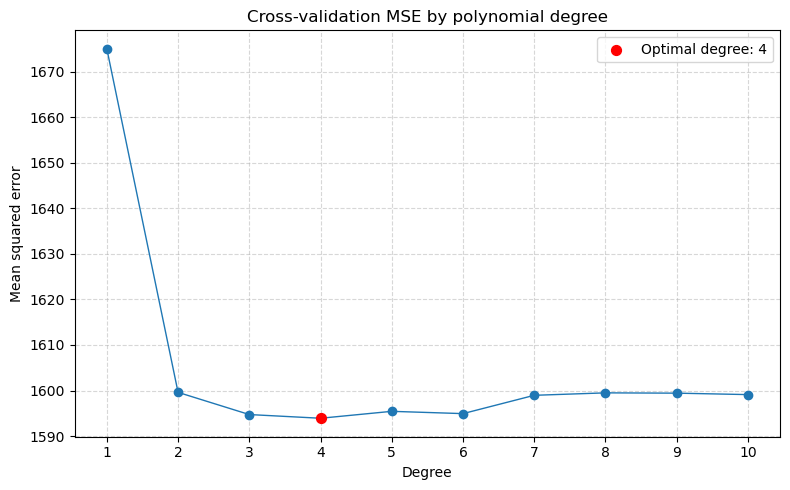

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(degrees, cv_scores, marker="o", linestyle="-", linewidth=1)
# Mark the minimum point:
min_score = cv_scores[optimal_degree - 1]
ax.scatter(optimal_degree, min_score, color="red", s=50, zorder=10,
           label=f"Optimal degree: {optimal_degree}")

ax.set_xlabel("Degree")
ax.set_ylabel("Mean squared error")
ax.set_title("Cross-validation MSE by polynomial degree")
ax.grid(True, linestyle="--", alpha=0.5)
ax.set_xticks(list(degrees))  # only show ticks for the degrees
ax.legend()
plt.tight_layout()
plt.show()

It is clear from the plot that linear regression has the worst performance, but
the fit does not seem to improve much by increasing the degree past $ d = 3 $.
Let's fit the optimal model found through cross-validation and the model having
degree $ 3 $:

In [8]:
optimal_pipeline = make_pipeline(
    PolynomialFeatures(degree=optimal_degree, include_bias=False),
    LinearRegression()
)
optimal_pipeline.fit(X, y)

degree3_pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    LinearRegression()
)
degree3_pipeline.fit(X, y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linearregression', LinearRegression())])

Now let's compare them by plotting both fits:

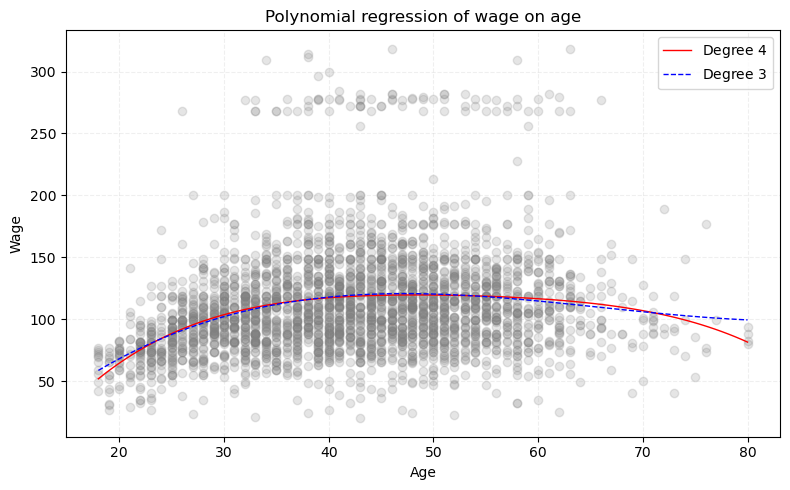

In [11]:
# Generate the data for plotting:
age_grid = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
optimal_wage_pred = optimal_pipeline.predict(age_grid)
degree3_wage_pred = degree3_pipeline.predict(age_grid)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, alpha=0.2, color="gray")
ax.plot(age_grid, optimal_wage_pred, color="red",
        linewidth=1, label=f"Degree $ {optimal_degree} $")
ax.plot(age_grid, degree3_wage_pred, color="blue",
        linewidth=1, linestyle="--", label="Degree $ 3 $")
ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.set_title(f"Polynomial regression of wage on age")
ax.grid(True, linestyle="--", alpha=0.2)
ax.legend()
plt.tight_layout()
plt.show()

There doesn't seem to be much of a difference between the two
models except for ages $ 70 \text{--} 80 $.  Now, let's compare our cross-validation results with ANOVA tests:

In [ ]:
print("ANOVA results")
print("-------------")
for d in range(1, 6):  # Testing only first 5 degrees for brevity
    # Fit model with degree d:
    formula_d = "wage ~ " + " + ".join([f"I(age**{i})" for i in range(1, d + 1)])
    model_d = ols(formula_d, data=Wage).fit()
    # Fit model with degree d + 1:
    formula_d_plus_1 = formula_d + f" + I(age**{d + 1})"
    model_d_plus_1 = ols(formula_d_plus_1, data=Wage).fit()
    # Perform ANOVA to compare models:
    anova_table = sm.stats.anova_lm(model_d, model_d_plus_1)
    print(f"\nComparing degree {d} vs {d + 1}:")
    print(anova_table)

ANOVA results
-------------

Comparing degree 1 vs 2:
   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.044054  3.077420e-32

Comparing degree 2 vs 3:
   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    2997.0  4.793430e+06      0.0           NaN       NaN       NaN
1    2996.0  4.777674e+06      1.0  15755.693664  9.880133  0.001687

Comparing degree 3 vs 4:
   df_resid           ssr  df_diff      ss_diff         F    Pr(>F)
0    2996.0  4.777674e+06      0.0          NaN       NaN       NaN
1    2995.0  4.771604e+06      1.0  6070.152124  3.810061  0.051039

Comparing degree 4 vs 5:
   df_resid           ssr  df_diff      ss_diff         F    Pr(>F)
0    2995.0  4.771604e+06      0.0          NaN       NaN       NaN
1    2994.0  4.770322e+06      1.0  1282.563017  0.804976  0.369682

Comparing degree 5 vs 6:

From these tests it appears that there is good reason to choose a polynomial 
regression model of degree $ 3 $, but not models of higher
degree.

__6 (b):__ Now, let's fit a step function to predict wage using age using
`KBinsDiscretizer` ($ K $-bins discretizer) from scikit-learn, relying on
cross-validation to determine the optimal number of cuts. We will
divide the bins using quantiles, as in the text:

In [20]:
n_cuts_range = range(2, 11)
cv_scores_cuts = []

# Perform cross-validation for each number of cuts:
for n_cuts in n_cuts_range:
    pipeline = make_pipeline(
        KBinsDiscretizer(n_bins=n_cuts, encode="onehot-dense", strategy="quantile"),
        LinearRegression()
    )
    scores = cross_val_score(
        pipeline, X, y, cv=5, scoring="neg_mean_squared_error"
    )
    cv_scores_cuts.append(-scores.mean())

# Find the optimal number of cuts:
optimal_cuts = n_cuts_range[np.argmin(cv_scores_cuts)]
print(f"Optimal number of cuts from cross-validation: {optimal_cuts}")

Optimal number of cuts from cross-validation: 8


Finally, we fit the step function with the optimal number of cuts ($ 8 $) and
plot it:

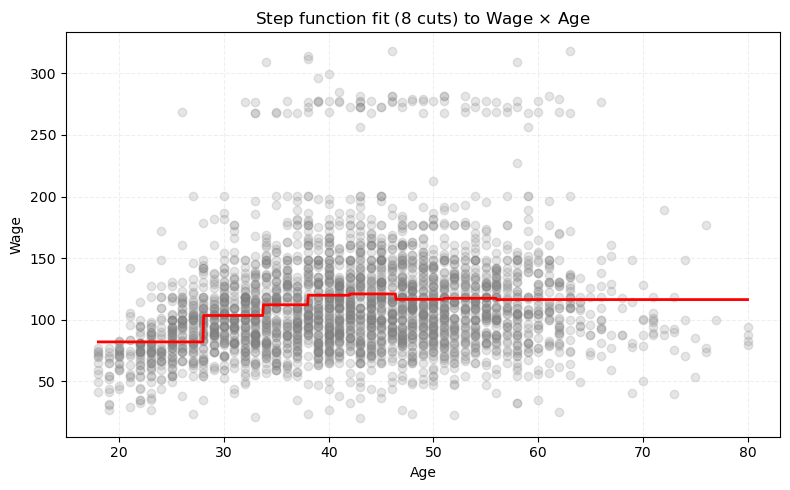

In [31]:
step_pipeline = make_pipeline(
    KBinsDiscretizer(n_bins=optimal_cuts, encode="onehot-dense", strategy="quantile"),
    LinearRegression()
)
step_pipeline.fit(X, y)

# Generate data for plotting, using a fine grid to capture the steps:
age_grid = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
wage_pred_step = step_pipeline.predict(age_grid)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, alpha=0.2, color="gray")
ax.plot(age_grid, wage_pred_step, color="red", linewidth=2)
ax.set_xlabel("Age")
ax.set_ylabel("Wage")
ax.set_title(f"Step function fit ({optimal_cuts} cuts) to Wage $ \\times $ Age")
ax.grid(True, linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()